In [6]:
TTS_PATH = "/home/arya/Documents/jaggukaka/TTS/TTS"

In [2]:
import os
import sys
sys.path.append(TTS_PATH) # set this if TTS is not installed globally
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.tts.datasets.formatters import *
%matplotlib inline

In [7]:
DATA_PATH = "/home/arya/Documents/jaggukaka/TTS/datasets/resampled_telugu_openslr"
META_DATA = ["te_in_female.tsv",
            "te_in_male.tsv"]
NUM_PROC = 8

In [8]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
items = openslr_in(DATA_PATH, META_DATA)
print(" > Number of audio files: {}".format(len(items)))

openslr_in - meta_files:  ['te_in_female.tsv', 'te_in_male.tsv']
 > Number of audio files: 4448


In [9]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item[1].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(waf_path)

In [10]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [11]:
def load_item(item):
    file_name = item[1].strip()
    text = item[0].strip()
    audio = librosa.load(file_name, sr=None)
    sr = audio[1]
    audio = audio[0]
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

100%|██████████| 4448/4448 [00:07<00:00, 574.66it/s]


In [12]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

100%|██████████| 4448/4448 [00:00<00:00, 384784.25it/s]

 > Number of words: 6051


In [60]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
dur_to_file = {}  # audio duration vs file name
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
        dur_to_file[text_len] += [item[0]]
    except:
        text_vs_durs[text_len] = [audio_len]
        dur_to_file[text_len] = [item[0]]

100%|██████████| 4448/4448 [00:00<00:00, 898967.10it/s]


In [50]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [51]:
print (list(text_vs_avg.items())[:5])

[(53, 6.378687074829933), (37, 4.6546396770090155), (31, 4.5482868480725624), (38, 4.971805704738035), (30, 4.100083144368858)]


In [52]:
for item in data:
    if item[-1] < 2:
        print(item)

('/home/arya/Documents/jaggukaka/TTS/datasets/resampled_telugu_openslr/te_in_female/tef_06625_01487098156.wav', 'చదవక తప్పదన్న మాట', 17, array([ 0.        ,  0.        ,  0.        , ..., -0.00045776,
       -0.00067139,  0.        ], dtype=float32), 1.9626757369614511)
('/home/arya/Documents/jaggukaka/TTS/datasets/resampled_telugu_openslr/te_in_female/tef_06625_02022822442.wav', 'ఇవి సునామీలు కావు', 17, array([ 0.0000000e+00, -3.0517578e-05,  0.0000000e+00, ...,
        6.1035156e-05,  3.0517578e-05,  0.0000000e+00], dtype=float32), 1.9626757369614511)
('/home/arya/Documents/jaggukaka/TTS/datasets/resampled_telugu_openslr/te_in_female/tef_07789_00619287256.wav', 'ఆంస్ట్రాంగ్ అండ్', 16, array([ 3.0517578e-05,  1.2207031e-04,  1.2207031e-04, ...,
       -2.4414062e-04, -2.7465820e-04,  0.0000000e+00], dtype=float32), 1.8773696145124716)
('/home/arya/Documents/jaggukaka/TTS/datasets/resampled_telugu_openslr/te_in_female/tef_04830_00914011632.wav', 'జనం నోళ్లలో నానలేదు', 19, array([ 0.000

In [53]:
sec_per_chars = []
unique_chars = {}
len_texts = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
    filtered_sentence = list(filter(lambda x : x != ' ', text))
    for i, k in enumerate(filtered_sentence):
        try:
            unique_chars[k] += 1
        except:
            unique_chars[k] = 1
    len_texts.append(len(text))
# sec_per_char /= len(data)
# print(sec_per_char)
filter_chars = {"pad": "_",
"eos": "&",
"bos": "*",
"characters": "!¡'(),-.:;¿?abcdefghijklmnopqrstuvwxyzµßàáâäåæçèéêëìíîïñòóôöùúûüąćęłńœśşźżƒабвгдежзийклмнопрстуфхцчшщъыьэюяёєіїґӧ «°±µ»$%&‘’‚“`”„",
"punctuations": "!¡'(),-.:;¿? "}
special_unique_chars = {}
for k,v in unique_chars.items():
    k = k.lower()
    knotinj = True
    for i, j in filter_chars.items():
        knotinj = knotinj and k not in j
    if knotinj:
        special_unique_chars[str(k).encode('unicode_escape').decode('utf-8')] = (ord(k), v)
    
print (''.join(special_unique_chars.keys()))

sample_sentence = data[0][1]
print(f'\n{sample_sentence}')
print(str(sample_sentence).encode('unicode_escape').decode('utf-8'))

\u0c08\u0c35\u0c3f\u0c3e\u0c26\u0c02\u0c38\u0c46\u0c2a\u0c4d\u0c1f\u0c2c\u0c30\u0c21\u0c41\u0c47\u0c32\u0c24\u0c4a\u0c2e\u0c28\u0c37\u0c15\u0c48\u0c12\u0c2f\u0c25\u0c20\u0c36\u0c09\u0c1a\u0c17\u0c33\u0c39\u0c4b\u0c42\u0c40\u0c05\u0c1c\u0c2b\\\u0c4c\u0c06\u0c23\u0c27\u0c0f\u0c07\u0c18\u0c16\u0c0e\u0c2d\u200c\u0c13\u0c43\u0c22\u0c0a\u0c10\u0c1b\u0c03\u0c1e\u0c0b\u0c14\u0c31/\u0c19\u0c01

ఈ వివాదం సెప్టెంబర్ రెండు వేల తొమ్మిదిన పరిష్కారమైనది
\u0c08 \u0c35\u0c3f\u0c35\u0c3e\u0c26\u0c02 \u0c38\u0c46\u0c2a\u0c4d\u0c1f\u0c46\u0c02\u0c2c\u0c30\u0c4d \u0c30\u0c46\u0c02\u0c21\u0c41 \u0c35\u0c47\u0c32 \u0c24\u0c4a\u0c2e\u0c4d\u0c2e\u0c3f\u0c26\u0c3f\u0c28 \u0c2a\u0c30\u0c3f\u0c37\u0c4d\u0c15\u0c3e\u0c30\u0c2e\u0c48\u0c28\u0c26\u0c3f


In [54]:
print ('\u0268'.encode('utf-8').decode('unicode_escape'))

É¨


In [55]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)
print(" | > Max length sequence: {}".format(np.max(len_texts)))
print(" | > Min length sequence: {}".format(np.min(len_texts)))
print(" | > Avg length sequence: {}".format(np.mean(len_texts)))

0.13640100815584494
0.048205071450233214
 | > Max length sequence: 97
 | > Min length sequence: 9
 | > Avg length sequence: 35.71380395683453


In [56]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    
    pdf = norm.pdf(sec_per_char)
    if pdf < 0.39:
        print(item)

('/home/arya/Documents/jaggukaka/TTS/datasets/resampled_telugu_openslr/te_in_female/tef_05994_01945384488.wav', 'తల నామవాచకంగా', 13, array([-1.2207031e-04, -9.1552734e-05, -1.5258789e-04, ...,
       -6.1035156e-05, -9.1552734e-05,  0.0000000e+00], dtype=float32), 3.7546938775510204)
('/home/arya/Documents/jaggukaka/TTS/datasets/resampled_telugu_openslr/te_in_female/tef_05691_02058763596.wav', 'ఈ గ్రామానికి సిటి బస్సుల సౌకర్యం ఉంది', 37, array([ 0.0000000e+00, -3.0517578e-05,  0.0000000e+00, ...,
        0.0000000e+00,  6.1035156e-05,  0.0000000e+00], dtype=float32), 8.277369614512471)
('/home/arya/Documents/jaggukaka/TTS/datasets/resampled_telugu_openslr/te_in_female/tef_05705_00377114098.wav', 'ఇండియా ఎ హిస్టరీ', 16, array([-6.1035156e-05, -9.1552734e-05, -6.1035156e-05, ...,
       -3.0517578e-05,  0.0000000e+00, -3.0517578e-05], dtype=float32), 3.4133333333333336)
('/home/arya/Documents/jaggukaka/TTS/datasets/resampled_telugu_openslr/te_in_female/tef_09935_01038244981.wav', 'యాభై మ

### Plot Dataset Statistics

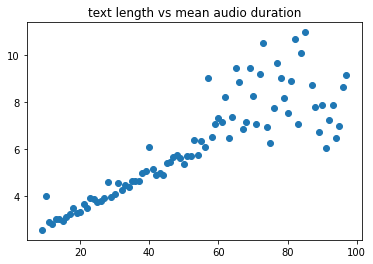

In [57]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))





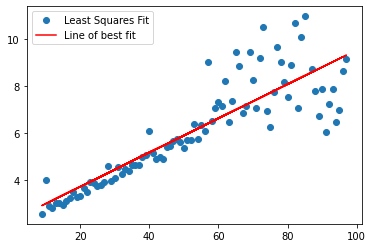

In [58]:
X = np.array(list(text_vs_avg.keys()))
Y = np.array(list(text_vs_avg.values()))

#least squares on X and Y
A = np.vstack([X, np.ones(len(X))]).T
m, c = np.linalg.lstsq(A, Y, rcond=None)[0]

# plot the line
plt.plot(X, Y, 'o', label='Least Squares Fit')
plt.plot(X, m*X + c, 'r', label='Line of best fit')
plt.legend()




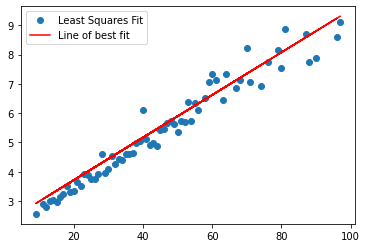

In [59]:
# filter outliers
X_filtered = []
Y_filtered = []
for i, x in enumerate(X):
    if abs(Y[i] - (m*x + c)) < 1:      
        X_filtered.append(x)
        Y_filtered.append(Y[i])

X_filtered = np.array(X_filtered)
Y_filtered = np.array(Y_filtered)
# plot the line
plt.plot(X_filtered, Y_filtered, 'o', label='Least Squares Fit')
plt.plot(X_filtered, m*X_filtered + c, 'r', label='Line of best fit')
plt.legend()

In [79]:
import random, shutil, pathlib
good_files = [j for x in X_filtered for j in dur_to_file[x]]
random.shuffle(good_files)
good_files = good_files[:500]

te_in_female = {}
te_in_male = {}

dest_folder = "/home/arya/Documents/jaggukaka/TTS/datasets/cutdowndata/"

for item in data:
    if item[0] in good_files:
        fname = pathlib.Path(item[0]).stem
        if 'tef' in fname:
            te_in_female[fname] = item[1]
            #create folder if doesnot exist
            pathlib.Path(dest_folder + 'te_in_female').mkdir(exist_ok=True)
            shutil.copy(item[0], dest_folder + 'te_in_female')
        else :
            te_in_male[fname] = item[1]
            pathlib.Path(dest_folder + 'te_in_male').mkdir(exist_ok=True)
            shutil.copy(item[0], dest_folder + 'te_in_male')


with open(dest_folder + 'te_in_female.tsv', "w+") as f:
    f.write("\n".join(["\t".join([k, v]) for k, v in te_in_female.items()]))
    f.close()

with open(dest_folder + 'te_in_male.tsv', "w+") as f:
    f.write("\n".join(["\t".join([k, v]) for k, v in te_in_male.items()]))
    f.close()
        
    

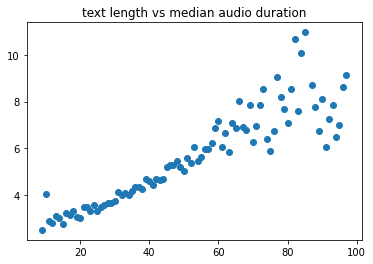

In [38]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

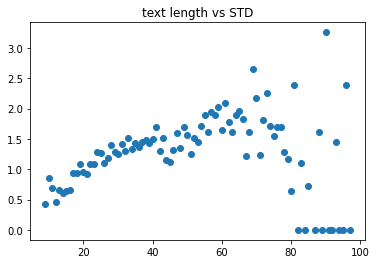

In [17]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

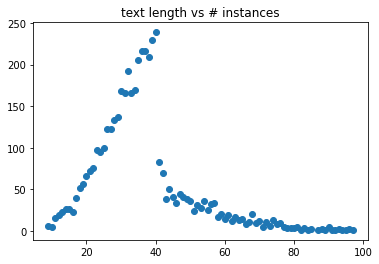

In [39]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

### Check words frequencies

In [40]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [41]:
w_count_df

,0
ఈ,396
ఒక,247
కూడా,182
రెండు,178
ఇది,165
...,...
ప్రాంతానికి,1
శోషరస,1
బహిరంగ,1
వాసన,1


In [44]:
# check a certain word
w_count_df.at['రెండు', 0]

178

In [22]:
# fequency bar plot - it takes time!!
w_count_df.plot.bar()

<AxesSubplot:>

/home/arya/Documents/coquitts/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3080 (\N{TELUGU LETTER II}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arya/Documents/coquitts/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arya/Documents/coquitts/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3090 (\N{TELUGU LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arya/Documents/coquitts/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3093 (\N{TELUGU LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arya/Documents/coquitts/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3138 (\N{TELUGU VOWEL SIGN UU}) missing from current font.
  fig.canvas.pr

Error in callback <function flush_figures at 0x7f6bd2e93af0> (for post_execute):


KeyboardInterrupt: 

In [30]:
import torch

In [31]:
torch.cuda.current_device()

0

In [32]:
torch.cuda.device(0)

In [33]:
torch.cuda.device_count()

1

In [34]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050 Ti'

In [35]:
torch.cuda.is_available()

True